In [1]:
# LOAD PACKAGES

import os
import shutil
import glob
import random
from datetime import datetime
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score
from PIL import Image
import h5py
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import torch
from torch import topk
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler, WeightedRandomSampler

import torchvision
from torchvision import datasets, models, transforms

%matplotlib inline

print(torch.__version__)  # should be >=0.4.1
print(torchvision.__version__)  # should be >=0.2.1

1.6.0
0.7.0


In [2]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Copy folder xyz from input folder to working directory (pwd to print working directory...) via console:
# cp -r input/xyz working/xyz


# Function to create a new folder if not already existing
def makeDir(pathString):
    if not os.path.exists(pathString):
        os.makedirs(pathString)

# Path settings
DATA_ROOT = "/kaggle/input/pytorch-opencv-course-classification/"
IMAGES_ROOT = DATA_ROOT + '/images/images/'
DATA_OUT = "/kaggle/output/kaggle/working/"
input_path = DATA_OUT + "images/"
trainPath = input_path + "train/"
valPath = input_path + "val/"
testPath = input_path + "test/1/"
submPath = DATA_OUT + "submission/"
predPath = DATA_OUT + "predictions/"
modelsPath = DATA_OUT + "models/"

# Create directories
makeDir(trainPath)
makeDir(testPath)
makeDir(submPath)
makeDir(predPath)
makeDir(modelsPath)

# Class names
classNames = np.array(["bhaji","chapati","githeri","kachumbari","kukuchoma","mandazi","masalachips","matoke","mukimo","nyamachoma","pilau","sukumawiki","ugali"])

# GPU SETTINGS
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

# Create tree structure
for i in range(classNames.size):
    makeDir(trainPath + classNames[i])

# Copy folder structure from train to val (including class subfolders)
shutil.copytree(trainPath, input_path + 'val/')

# Read labels
label_csv_path1 = os.path.join(DATA_ROOT, 'train.csv')
label_csv_path2 = os.path.join(DATA_ROOT, 'test.csv')
label_df1 = pd.read_csv(label_csv_path1, delimiter=' *, *', engine='python')
label_df2 = pd.read_csv(label_csv_path2, delimiter=' *, *', engine='python')

# train / validation split
threshold = 0.8

# Minimum validation accuracy to be reached in competition. Models below this value won't be saved.
minValAcc = 0.75

# Set seed number to set the state of all random number generators (repeatability...)
seed: int = 21

In [3]:
# SORT IMAGES INTO TRAIN/VAL/TEST AND INTO CLASS SUBFOLDERS (in working directory -> writing permission!)

# Copy TRAIN images from input directory (read only!) to working directory (writing permission!)
for i in range(len(label_df1)):
    item = str(label_df1.loc[i,'id']) + '.jpg'
    file_path = os.path.join(IMAGES_ROOT, item)
    label = str(label_df1.loc[i,'class'])
    class_folder = trainPath + label + '/'
    if os.path.isfile(file_path):
        shutil.copy(file_path, class_folder)

# Copy TEST images from input directory (read only!) to working directory (writing permission!)
for i in range(len(label_df2)):
    item = str(label_df2.loc[i,'id']) + '.jpg'
    file_path = os.path.join(IMAGES_ROOT, item)
    if os.path.isfile(file_path):
        shutil.copy(file_path, testPath)

# Move XX% of images per train/classXX folder to validation/classXX folder (according to threshold for train/validation split)
for name in os.listdir(trainPath):
    # copy structure from train folder to validation folder; create class folder if it doesn't exist
    valPathTemp = valPath + name
    makeDir(valPathTemp)
    # create list of files that are contained in classXX folder
    files = glob.glob(trainPath+name+'/*') # os.path.relpath, os.path.basename
    # shuffle file order
    random.shuffle(files)
    # get number of files
    numImg = len(files)
    #print(name)
    # move first 100%-XX% (round!) to validation structure
    for i in range(round(numImg*(1-threshold))):
        shutil.move(files[i], valPathTemp)

In [4]:
# GENERAL MODEL SETTINGS

# define CNN model to be used
num_classes = 13
feature_extract = True # do not change!
model_name = "resnext50"
num_epochs=100 # 50
batch_size=16 # 32
fine_tune_start = 1

# use per-class weights
classWeightsBool = True

## Decay Learning Rate by a factor of gamma every step_size epochs
#step_size=7
#gamma=0.1

# Early stopping details
n_epochs_stop = round(num_epochs/1) # de facto, round(num_epochs/1) means: no early stopping...
min_val_loss = np.Inf
epochs_no_improve = 0

In [5]:
# DATA AUGMENTATION

# ImageNet parameters for normalization.
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

# Input size of images for CNN (e.g., 224 for ResNet18 or ResNet50).
inputSize = (224)

# crop size
cropSize = (256)

# Set parameters for data augmentation.
angle=15
flipAcc = 0.5
translate = (0.25, 0.25)
scale = (0.66,1.5)

# Definition of data transformations (= data augmentation) for different phases train, validation, and test.
# https://pytorch.org/docs/stable/torchvision/transforms.html
data_transforms = {
    'train':
    transforms.Compose([
        #transforms.RandomResizedCrop(cropSize),
        transforms.Resize(cropSize),
        transforms.RandomAffine(degrees=(-angle,angle), translate=translate, scale=scale),
        #transforms.ColorJitter(), # brightness=0.5, contrast=0.5, saturation=0.3
        transforms.RandomHorizontalFlip(p=flipAcc),
        transforms.CenterCrop(inputSize),
        # transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False),
        # Randomly selects a rectangle region in an image and erases its pixels. ‘Random Erasing Data Augmentation’ by Zhong et al. See https://arxiv.org/abs/1708.04896
        # p – probability that the random erasing operation will be performed.
        # scale – range of proportion of erased area against input image.
        # ratio – range of aspect ratio of erased area.
        # value – erasing value. Default is 0. If a single int, it is used to erase all pixels. If a tuple of length 3, it is used to erase R, G, B channels respectively. If a str of ‘random’, erasing each pixel with random values.
        # inplace – boolean to make this transform inplace. Default set to False.
        transforms.ToTensor(),
        transforms.Normalize(mean=mean,std=std, inplace=False)
    ]),
    'val':
    transforms.Compose([
        transforms.Resize(cropSize),
        transforms.CenterCrop(inputSize),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean,std=std, inplace=False)
    ]),
    'test':
    transforms.Compose([
        transforms.Resize(cropSize),
        transforms.CenterCrop(inputSize),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean,std=std, inplace=False)
    ])
}

In [6]:
# DATALOADER

# Image datesets
image_datasets = {
    'train':
    datasets.ImageFolder(trainPath, data_transforms['train']),
    'val':
    datasets.ImageFolder(valPath, data_transforms['val']),
    'test':
    datasets.ImageFolder(input_path + "test/", data_transforms['test'])
}

# Dataloader for training and validation (incl. shuffle)
dataloaders = {
    'train':
    torch.utils.data.DataLoader(image_datasets['train'], batch_size=batch_size, shuffle=True, num_workers=0),
    'val':
    torch.utils.data.DataLoader(image_datasets['val'], batch_size=batch_size, shuffle=True, num_workers=0)
}

# Dataloader for inference using trained model (batch_size=1, no shuffle) -> 1) model testing, 2) feature extraction, 3) CAM generation
dataloaders2 = {
    'train':
    torch.utils.data.DataLoader(image_datasets['train'], batch_size=1, shuffle=False, num_workers=0),
    'val':
    torch.utils.data.DataLoader(image_datasets['val'], batch_size=1, shuffle=False, num_workers=0),
    'test':
    torch.utils.data.DataLoader(image_datasets['test'], batch_size=1, shuffle=False, num_workers=0)
}

In [7]:
# UTILS: Function to FREEZE / UNFREEZE all model layers
def set_parameter_requires_grad(model, feature_extracting, reqGrad):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = reqGrad


# UTILS: Function to INITIALIZE models
def initialize_model(model_name, num_classes, feature_extract, use_pretrained):
    # Initialize these variables which will be set in this if statement. Each of these variables is model specific.
    model_ft = None
    input_size = 0
    
    if model_name == "resnext50":
        """ ResNeXt50
        """
        model_ft = models.resnext50_32x4d(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract, False)
        num_ftrs = model_ft.fc.in_features
        #model_ft.fc = nn.Linear(num_ftrs, num_classes).to(device)
        #model_ft.fc = nn.Sequential(nn.Linear(num_ftrs, 64),nn.ReLU(inplace=True),nn.Linear(64, num_classes)).to(device)
        # ### DROPOUT in CLASSIFIER: https://towardsdatascience.com/batch-normalization-and-dropout-in-neural-networks-explained-with-pytorch-47d7a8459bcd
        model_ft.fc = nn.Sequential(nn.Linear(num_ftrs, 256),nn.Dropout(0.5),nn.ReLU(inplace=True),nn.Linear(256, 32),
                                   nn.Dropout(0.2),nn.ReLU(inplace=True),nn.Linear(32, num_classes)).to(device)
        input_size = 224

    if model_name == "resnet18":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract, False)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes).to(device)
        #model_ft.fc = nn.Sequential(nn.Linear(num_ftrs, 32),nn.ReLU(inplace=True),nn.Linear(32, num_classes)).to(device)
        input_size = 224
        
    elif model_name == "resnet50":
        """ Resnet50
        """
        model_ft = models.resnet50(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract, False)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes).to(device)
        # model_ft.fc = nn.Sequential(nn.Linear(num_ftrs, 128),nn.ReLU(inplace=True),nn.Linear(128, num_classes)).to(device)
        input_size = 224
        
    elif model_name == "resnet152":
        """ Resnet152
        """
        model_ft = models.resnet152(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract, False)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes).to(device)
        #model_ft.fc = nn.Sequential(nn.Linear(num_ftrs, 128),nn.ReLU(inplace=True),nn.Linear(128, num_classes)).to(device)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract, False)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 227 # literature says 227!

    elif model_name == "vgg":
        """ VGG11_bn / vgg19_bn
        """
        model_ft = models.vgg19_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract, False)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract, False)
        num_ftrs = 512
        model_ft.classifier[1] = nn.Conv2d(num_ftrs, num_classes, kernel_size=1, stride=1) # for images: kernel_size=5, stride=1, padding=2
        model_ft.num_classes = num_classes
        input_size = 227 # literature says 227!

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract, False)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract, False)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    #else:
    #    print("Invalid model name, exiting...")
    #    exit()

    return model_ft, input_size, num_ftrs


# UTILS: CALCULATE CLASS WEIGHTS
def calcClassWeights(classWeightsBool):
    if classWeightsBool == True:
        print("Class weights are used in loss functon.")
        # read class weights from csv
        df = pd.read_csv('/kaggle/input/class-weights/weights.csv')
        df.head()
        
        # calculate class counts
        counts = np.array(df['count'], dtype=np.float32)
        
        # calculate class weights as inverse values of counts
        #weights = np.cbrt(max(counts)/counts).round()
        weights = (sum(counts)/counts).round()
        weights = weights/max(weights) # normalization
        
    elif classWeightsBool == False:
        print("Class weights are NOT used in loss functon.")
        weights = np.ones(num_classes) # same weight (1) for all classes

    # array to tensor
    weights = torch.FloatTensor(weights).to(device)
    #print(weights)
    
    return weights


# UTILS: Train function
def train_model(model, model_name, criterion, optimizer, scheduler, num_epochs, n_epochs_stop, min_val_loss, epochs_no_improve, retrain_code):
    
    # initialize empty arrays
    epoch_train_loss = np.array([])
    epoch_train_acc = np.array([])
    epoch_val_loss = np.array([])
    epoch_val_acc = np.array([])    
     
    for epoch in range(num_epochs):
        
        # Check early stopping condition
        if epochs_no_improve == n_epochs_stop:
            print('Early stopping!')
            break # force end of training
            
        # initialize empty arrays
        preds_val = np.array([])
        labels_val = np.array([])        
        
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)
        
        for phase in ['train','val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad() # set gradients to 0
                    loss.backward() # compute gradients
                    optimizer.step() # update weights
                    
                _, preds = torch.max(outputs, 1) # preds: predicted class labels
                running_loss += loss.item() * inputs.size(0) # double; loss.item(): double; inputs.size(0): 32
                running_corrects += torch.sum(preds == labels.data) # double: How many labels were predicted correctly?

                if phase == 'val':
                    # concatenate predicted and actual labels
                    preds_val = np.concatenate((preds_val, preds.cpu().numpy()), axis=None)
                    #print(preds_val)
                    labels_val = np.concatenate((labels_val, labels.data.cpu().numpy()), axis=None)

            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.double() / len(image_datasets[phase])
            
            if phase == 'train':
                epoch_train_loss = np.append(epoch_train_loss, [epoch_loss])
                epoch_train_acc = np.append(epoch_train_acc, [epoch_acc])
            elif phase == 'val':
                epoch_val_loss = np.append(epoch_val_loss, [epoch_loss])
                epoch_val_acc = np.append(epoch_val_acc, [epoch_acc])                
            
            print('{} loss: {:.4f}, acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
           
            if phase == 'val':
                '''
                # print kappa, confusion_matrix and classification_report for validation dataset
                kappa = cohen_kappa_score(labels_val,preds_val, labels=None, weights=None, sample_weight=None)
                print('Cohen’s kappa (on validation dataset): ' + str(round(kappa,4)))
                print(confusion_matrix(labels_val,preds_val))
                print(classification_report(labels_val,preds_val, digits=4))
                '''
                
                # If validation accuracy exceeds minValAcc (e.g., 0.75), save the model.
                #if epoch_loss < min_val_loss or epoch_acc >= minValAcc:
                if epoch_acc >= minValAcc:
                    epoch_loss_str = str(round(epoch_loss, 4))
                    epoch_acc_str = str(epoch_acc.cpu().numpy().round(decimals=4, out=None))
                    model_str = "weights_"+model_name+"_retrain_"+retrain_code+"_epoch"+str(epoch+1)+"_valLoss"+epoch_loss_str+"_valAcc"+epoch_acc_str+".h5"
                    torch.save(model.state_dict(), modelsPath + model_str)
                # If the validation loss is at a new minimum, ...
                if epoch_loss < min_val_loss:
                    epochs_no_improve = 0 # ...set counter "epochs_no_improve" back to zero and...
                    min_val_loss = epoch_loss # ...update min_val_loss. Else,...
                else:
                    epochs_no_improve += 1 # ...increase number of epochs with no improve.
    
    return epoch_train_loss, epoch_train_acc, epoch_val_loss, epoch_val_acc # model_str


# UTILS: Function to test the trained model on unseen (independent) data
def test_model(model_name, num_classes, feature_extract, use_pretrained, model_str, device):
    
    # Initialize model using random weights
    model_trained, input_size, num_ftrs = initialize_model(model_name, num_classes, feature_extract, use_pretrained)
    # Load pre-trained weights from model with best performance on validation data
    model_trained.load_state_dict(torch.load(modelsPath + model_str))
    # Send model to GPU
    model_trained = model_trained.to(device)
    # set model to eval mode
    model_trained.eval()
    # create logfile for storing results
    logName = predPath + "logTest_"+model_str[8:-3]+".txt"
    logfile_test = open(logName,"w")  
    logfile_test.write(input_path + "\n") #logfile_test.write(model_name + "\n")
    # initialize empty arrays and variables
    preds_test = np.array([])
    i = 0
    j = 0
    # predict labels on test data
    for inputs, labels in dataloaders2['test']:
        if j%500 == 0:
            print(i)
            j = 0
        
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model_trained(inputs)
        _, preds = torch.max(outputs, 1) # preds: predicted class labels
        
        # write predictions to log file
        logfile_test.write(str(preds.cpu().numpy()[0]) + '\n')
        # concatenate predicted labels
        preds_test = np.concatenate((preds_test, preds.cpu().numpy()), axis=None)
        
        i = i+1
        j = j+1

    # close log file
    logfile_test.close()
    
    return logName


# UTILS: CREATE SUBMISSION FILE
def createSubmissionFile(logName,model_str):
    
    # read file names of test images into list
    imgs = ['{}'.format(i) for i in os.listdir(testPath)]
    imgName = []
    
    for i in range(len(imgs)):
        aaa = os.path.splitext(str(imgs[i]))[0]
        imgName += [aaa]
    imgName = pd.DataFrame(imgName)

    # read class names to dataframe
    df_names = pd.read_csv('/kaggle/input/classids/classIDs.csv') # dtype=str

    # read predictions to dataframe
    df_pred = pd.read_csv(logName,"w")

    # concatenate data frames
    df_subm = pd.concat([imgName.iloc[:,0:1],df_pred.iloc[:,0:1]], axis=1) # df.iloc[:,0:1] same as df[['Id']]

    # rename columns
    print(df_subm.columns)
    df_subm.columns = ['id', 'class']

    # left outer join to match class numbers to class names
    df_merged = df_subm.merge(df_names, left_on='class', right_on='id', sort=False)

    # delete redundant column
    df_merged = df_merged.drop(['class', 'id_y'], axis=1)
    df_merged.columns = ['id', 'class']

    # write to csv file
    #df_merged.to_csv(submPath + 'submission_'+model_str[8:-3]+'.csv', index=False)
    df_merged.to_csv(DATA_OUT + 'submission_'+model_str[8:-3]+'.csv', index=False)
    return

# UTILS: Function to freeze / unfreeze conv layers
def freezeLayers(fine_tune_start):
    
    if fine_tune_start == 0:
        retrain = [False,False,False,False]
    elif fine_tune_start == 1:
        retrain = [False,False,False,True]
    elif fine_tune_start == 2:
        retrain = [False,False,True,True]
    elif fine_tune_start == 3:
        retrain = [False,True,True,True]
    elif fine_tune_start == 4:
        retrain = [True,True,True,True]
    
    retrain_code = np.array(retrain).astype(int).astype(str)[0]+np.array(retrain).astype(int).astype(str)[1]+np.array(retrain).astype(int).astype(str)[2]+np.array(retrain).astype(int).astype(str)[3]
    
    return retrain, retrain_code

# UTILS: PLOT LOSS AND ACCURACY

def plot_loss_accuracy(train_loss, val_loss, train_acc, val_acc,
                       colors, loss_legend_loc='upper center', acc_legend_loc='upper left', 
                       fig_size=(20, 10), sub_plot1=(1, 2, 1), sub_plot2=(1, 2, 2)):
    
    plt.rcParams["figure.figsize"] = fig_size
    fig = plt.figure()
    
    plt.subplot(sub_plot1[0], sub_plot1[1], sub_plot1[2])
    
    for i in range(len(train_loss)):
        x_train = range(len(train_loss[i]))
        x_val = range(len(val_loss[i]))
        
        min_train_loss = train_loss[i].min()
        
        min_val_loss = val_loss[i].min()
        
        plt.plot(x_train, train_loss[i], linestyle='-', color='tab:{}'.format(colors[i]), 
                 label="TRAIN LOSS ({0:.4})".format(min_train_loss))
        plt.plot(x_val, val_loss[i], linestyle='--' , color='tab:{}'.format(colors[i]), 
                 label="VALID LOSS ({0:.4})".format(min_val_loss))
        
    plt.xlabel('epoch no.')
    plt.ylabel('loss')
    plt.legend(loc=loss_legend_loc)
    plt.title('Training and Validation Loss')
        
    plt.subplot(sub_plot2[0], sub_plot2[1], sub_plot2[2])
    
    for i in range(len(train_acc)):
        x_train = range(len(train_acc[i]))
        x_val = range(len(val_acc[i]))
        
        max_train_acc = train_acc[i].max() 
        
        max_val_acc = val_acc[i].max() 
        
        plt.plot(x_train, train_acc[i], linestyle='-', color='tab:{}'.format(colors[i]), 
                 label="TRAIN ACC ({0:.4})".format(max_train_acc))
        plt.plot(x_val, val_acc[i], linestyle='--' , color='tab:{}'.format(colors[i]), 
                 label="VALID ACC ({0:.4})".format(max_val_acc))
        
    plt.xlabel('epoch no.')
    plt.ylabel('accuracy')
    plt.legend(loc=acc_legend_loc)
    plt.title('Training and Validation Accuracy')
    
    plt.show()
    fig.savefig(DATA_OUT+'sample_loss_acc_plot.png')
    
    return

In [8]:
# MAIN FUNCTION

def main():
    
    # Calculate class weights
    weights = calcClassWeights(classWeightsBool)
    
    # Initialize the model for this run (using imagenet weights)
    model, input_size, num_ftrs = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)
    model = model.to(device)
    print('Number of features: '+ str(num_ftrs))

    # freeze / unfreeze conv layer
    retrain, retrain_code = freezeLayers(fine_tune_start)
    print(retrain)
    set_parameter_requires_grad(model.layer1, feature_extract, retrain[0])
    set_parameter_requires_grad(model.layer2, feature_extract, retrain[1])
    set_parameter_requires_grad(model.layer3, feature_extract, retrain[2])
    set_parameter_requires_grad(model.layer4, feature_extract, retrain[3])

    ## check which layers are UNfreezed (= will be retrained)
    #for name, param in model.named_parameters():
    #    if param.requires_grad == True:
    #        print(name, ':', param.requires_grad)
    
    # Find total parameters and trainable parameters
    total_params = sum(p.numel() for p in model.parameters())
    print(f'{total_params:,} total parameters.')
    total_trainable_params = sum(
        p.numel() for p in model.parameters() if p.requires_grad)
    print(f'{total_trainable_params:,} training parameters.')
    
    # Hyperparameters
    criterion = nn.CrossEntropyLoss(weight=weights) # weight: 1D Tensor assigning weight to each class (useful for unbalanced training set
    criterion.to(device)
    
    # Def. of class "torch.optim.Adam": https://pytorch.org/docs/stable/optim.html
    optimizer = optim.Adam(model.parameters()) # (params, lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-2, amsgrad=False)
    
    ## Decay LR by a factor of gamma (i.e. 0.1) every step_size (i.e. 7) epochs
    #scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    # LR scheduler
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, threshold=0.0001,
                                               threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=False)
    
    # Train and validate model
    train_loss, train_acc, val_loss, val_acc = train_model(model=model, model_name=model_name, criterion=criterion, optimizer=optimizer,
                                                           scheduler=scheduler, num_epochs=num_epochs, n_epochs_stop=n_epochs_stop,
                                                           min_val_loss=min_val_loss, epochs_no_improve=epochs_no_improve, retrain_code=retrain_code)
    
    # PLOT RESULTS
    plot_loss_accuracy(train_loss=[train_loss], val_loss=[val_loss], train_acc=[train_acc], val_acc=[val_acc], colors=['blue'],
                       loss_legend_loc='upper center', acc_legend_loc='upper left')

    # List of models that were saved during training
    modelNames = os.listdir(modelsPath)
    print(modelNames)
    
    # Create submission files for all saved models
    for i in range(len(modelNames)):
        model_str = modelNames[i]
        #use_pretrained=False
        logName = test_model(model_name, num_classes, feature_extract, False, model_str, device) # use_pretrained=False
        print(logName)
        createSubmissionFile(logName,model_str)
        
    return

resnext50
Current Time = 09:04:20
Class weights are used in loss functon.


Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth



Number of features: 2048
[False, False, False, True]
23,513,101 total parameters.
15,078,093 training parameters.
Epoch 1/100
----------
train loss: 2.2501, acc: 0.2875
val loss: 1.7676, acc: 0.4564
Epoch 2/100
----------
train loss: 1.9292, acc: 0.3875
val loss: 1.4842, acc: 0.4740
Epoch 3/100
----------
train loss: 1.7842, acc: 0.4231
val loss: 1.5040, acc: 0.5015
Epoch 4/100
----------
train loss: 1.6578, acc: 0.4524
val loss: 1.4095, acc: 0.5268
Epoch 5/100
----------
train loss: 1.6425, acc: 0.4621
val loss: 1.3201, acc: 0.5849
Epoch 6/100
----------
train loss: 1.5339, acc: 0.4994
val loss: 1.2710, acc: 0.5917
Epoch 7/100
----------
train loss: 1.4660, acc: 0.5306
val loss: 1.2176, acc: 0.6391
Epoch 8/100
----------
train loss: 1.3817, acc: 0.5520
val loss: 1.1468, acc: 0.6644
Epoch 9/100
----------
train loss: 1.3499, acc: 0.5511
val loss: 1.1580, acc: 0.6338
Epoch 10/100
----------
train loss: 1.3293, acc: 0.5738
val loss: 1.2972, acc: 0.6101
Epoch 11/100
----------
train loss

train loss: 0.2848, acc: 0.9126
val loss: 1.4744, acc: 0.7393
Epoch 96/100
----------
train loss: 0.2868, acc: 0.9170
val loss: 1.5745, acc: 0.7248
Epoch 97/100
----------
train loss: 0.2954, acc: 0.9147
val loss: 1.6887, acc: 0.7255
Epoch 98/100
----------
train loss: 0.2451, acc: 0.9288
val loss: 1.5273, acc: 0.7362
Epoch 99/100
----------
train loss: 0.2468, acc: 0.9283
val loss: 1.6861, acc: 0.7332
Epoch 100/100
----------
train loss: 0.2530, acc: 0.9294
val loss: 1.2727, acc: 0.7408


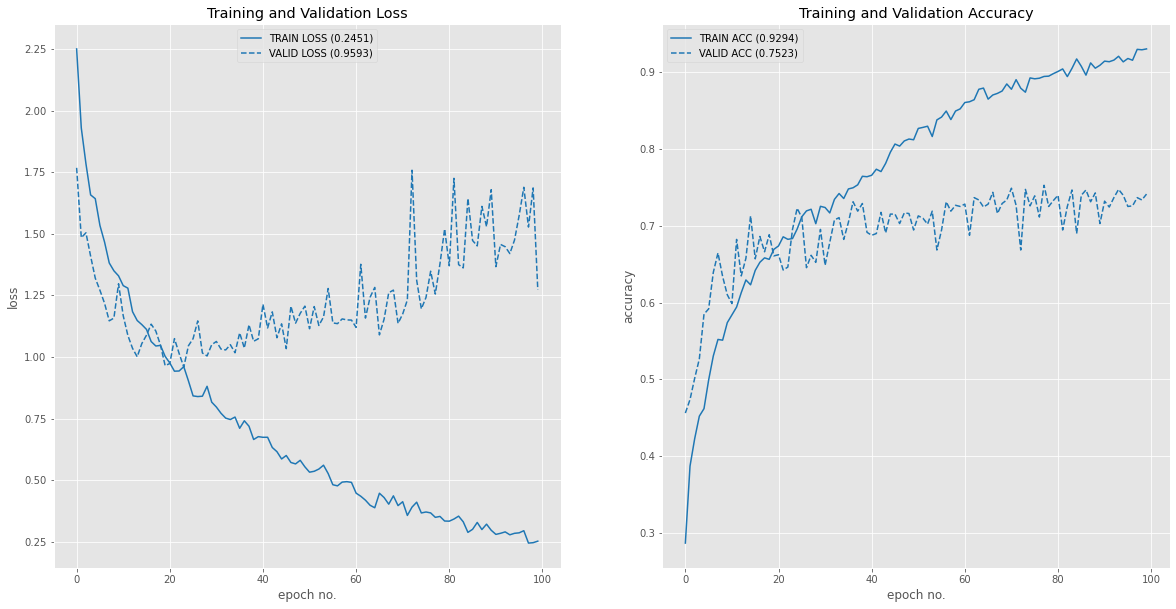

['weights_resnext50_retrain_0001_epoch78_valLoss1.2555_valAcc0.7523.h5']
0
500
1000
1500
/kaggle/output/kaggle/working/predictions/logTest_resnext50_retrain_0001_epoch78_valLoss1.2555_valAcc0.7523.txt
Index([0, '/kaggle/output/kaggle/'], dtype='object')


In [9]:
# EXPERIMENTS

# Printouts
print(model_name)
now = datetime.now()
print("Current Time =", now.strftime("%H:%M:%S"))

# RUN MAIN FUNCTION
main()

In [10]:
# CLEAN UP: Remove image folder from output directory
if os.path.exists(input_path) and os.path.isdir(input_path):
    shutil.rmtree(input_path)

In [11]:
'''
from IPython.display import FileLink, FileLinks
os.chdir(DATA_OUT)
FileLinks(submPath) #lists all downloadable files in "submPath" folder
'''

'''
# freeze / unfreeze conv layer
for param in resnet.parameters():
    param.requires_grad = False
if fine_tune_start <= 1:
    for param in resnet.layer1.parameters():
        param.requires_grad = True    
if fine_tune_start <= 2:
    for param in resnet.layer2.parameters():
        param.requires_grad = True
if fine_tune_start <= 3:
    for param in resnet.layer3.parameters():
        param.requires_grad = True
if fine_tune_start <= 4:
    for param in resnet.layer4.parameters():
        param.requires_grad = True
'''

'\n# freeze / unfreeze conv layer\nfor param in resnet.parameters():\n    param.requires_grad = False\nif fine_tune_start <= 1:\n    for param in resnet.layer1.parameters():\n        param.requires_grad = True    \nif fine_tune_start <= 2:\n    for param in resnet.layer2.parameters():\n        param.requires_grad = True\nif fine_tune_start <= 3:\n    for param in resnet.layer3.parameters():\n        param.requires_grad = True\nif fine_tune_start <= 4:\n    for param in resnet.layer4.parameters():\n        param.requires_grad = True\n'